In [2]:
from functions_py import *
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy.ma as ma
import pandas as pd 
# import cv2
import skimage as sk
import scipy.ndimage as nd
from array import array
from functions_MuonsNSAMP1 import *
import time

from ROOT import TProfile, TGraphErrors, TH2F

def gaussian(x, a, mean, sigma):
    return a * np.exp(-((x - mean)**2 / (2 * sigma**2)))

# def Gaussian2(x,m1,s1,g1,a1, m2, s2, g2, a2): #data, mean, sigma, gain, height1, heigth2
#     return a1*np.exp(-1/2*((x-m1-g1)/s1)**2) + a2*np.exp(-1/2*((x-m2-g2)/s2)**2)

def Gaussian2(x,m,s,g,a1,a2): #data, mean, sigma, gain, height1, heigth2
    return a1*np.exp(-1/2*((x-m)/s)**2)+a2*np.exp(-1/2*((x-m-g)/s)**2)


def EnergySpectrum(x, N):
    return N * np.sin(x)*np.cos(x)**3

Colormap = 'jet'

# print(time.time())
# print(time.gmtime(0))

Welcome to JupyROOT 6.28/04


In [3]:
plt.rcParams.update({
    "image.origin": "lower",
    "image.aspect": 1,
    #"text.usetex": True,
    "grid.alpha": .5,
    "axes.linewidth": 3,
    "lines.linewidth" : 1,
    "font.size":    15.0,
    "xaxis.labellocation": 'right',  # alignment of the xaxis label: {left, right, center}
    "yaxis.labellocation": 'top',  # alignment of the yaxis label: {bottom, top, center}
    "xtick.top":           True ,  # draw ticks on the top side
    "xtick.major.size":    8    ,# major tick size in points
    "xtick.minor.size":    4      ,# minor tick size in points
    "xtick.direction":     'in',
    "xtick.minor.visible": True,
    "ytick.right":           True ,  # draw ticks on the top side
    "ytick.major.size":    8    ,# major tick size in points
    "ytick.minor.size":    4      ,# minor tick size in points
    "ytick.direction":     'in',
    "ytick.minor.visible": True,
    "ytick.major.width":   2   , # major tick width in points
    "ytick.minor.width":   1 ,
    "xtick.major.width":   2   , # major tick width in points
    "xtick.minor.width":   1 ,
    "legend.framealpha": 0 ,
    "legend.loc": 'best',

})

Colormap = 'jet'

Filename: /home/labdet/Documents/MauSan/Programas/Repositorio_Git/images/AGO2024/proc_skp_m-009_microchip_T_170__NSAMP_324_NROW_650_NCOL_700_EXPOSURE_0_img_100.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     165   (700, 650)   float32   
  1                1 ImageHDU       164   (700, 650)   float32   
  2                1 ImageHDU       164   (700, 650)   float32   
  3                1 ImageHDU       164   (700, 650)   float32   
None
----------------


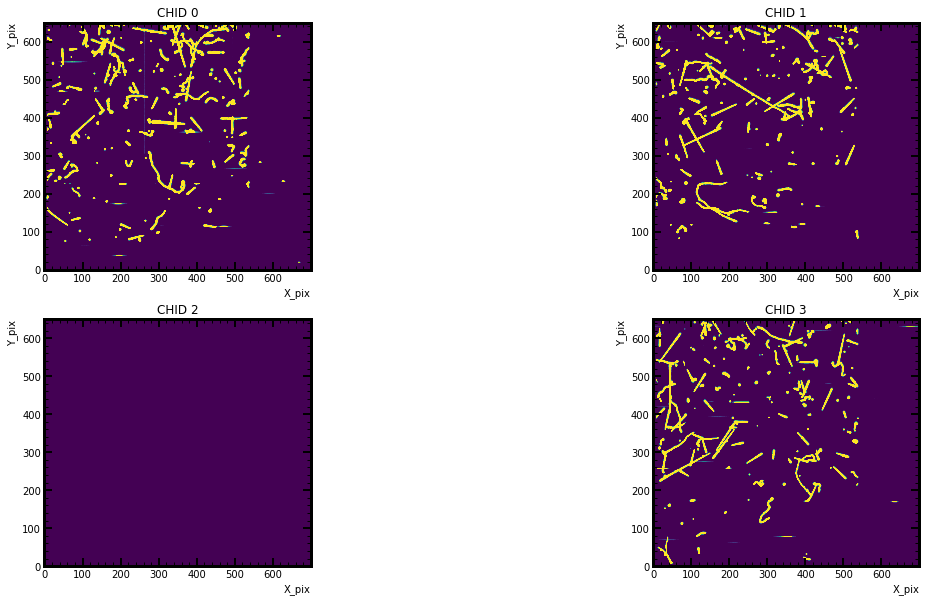

In [3]:
# path = '/home/bruce/Documents/Programas/images/AGO2024/proc_skp_m-009_microchip_T_170__NSAMP_324_NROW_650_NCOL_700_EXPOSURE_0_img_100.fits'
# path = '/home/bruce/Documents/Programas/images/AGO2024/proc_skp_m-009_microchip_T_170__NSAMP_324_NROW_650_NCOL_700_EXPOSURE_0_img_101.fits'
# path = '/home/bruce/Documents/Programas/images/AGO2024/proc_skp_m-009_microchip_T_170__NSAMP_324_NROW_650_NCOL_700_EXPOSURE_0_img_102.fits'

path = '/home/labdet/Documents/MauSan/Programas/Repositorio_Git/images/AGO2024/proc_skp_m-009_microchip_T_170__NSAMP_324_NROW_650_NCOL_700_EXPOSURE_0_img_100.fits'


hdu_list = fits.open(path)
print(hdu_list.info())
print('----------------')
# hdu_list[0].header
plt.figure(figsize=(20,10))
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.imshow(hdu_list[i].data-np.median(hdu_list[i].data),vmin=1000,vmax=10000, cmap = 'viridis')
    plt.title('CHID '+str(i))
    plt.ylabel('Y_pix')
    plt.xlabel('X_pix')
plt.show()

# Sustrayendo el promedio por renglón

## Sustrayendo la media del renglon

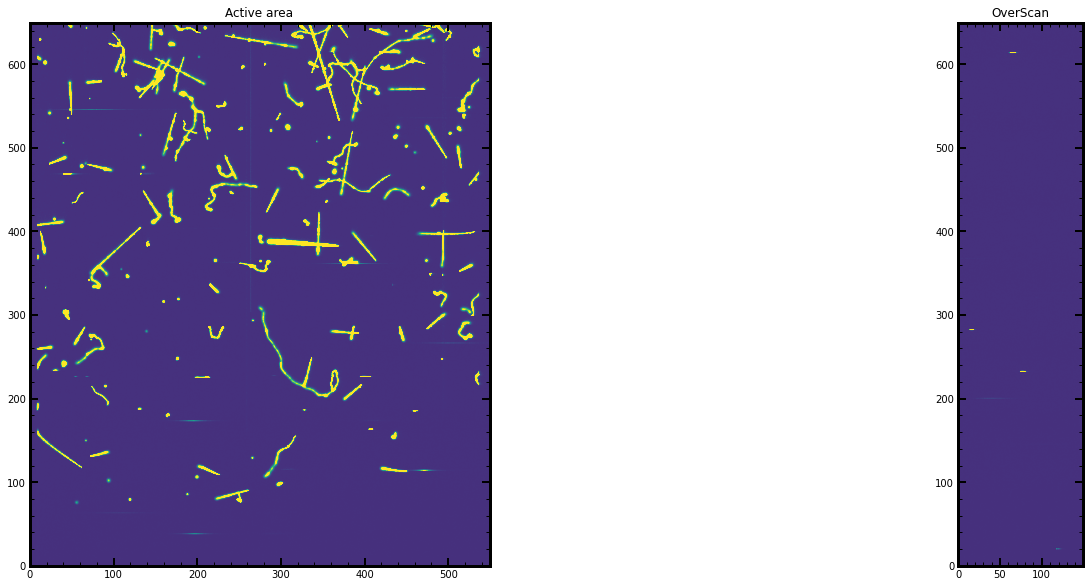

In [4]:
### Muestra el area activa y overscan de la extensión 

extension = 1
# plt.imshow(hdu_list[0].data[:, 550:], vmin = 0, vmax = 80000, origin = 'lower')
Overscan = hdu_list[extension - 1].data[:, 550:]
active_area = hdu_list[extension - 1].data[:, :550]


fig, axs = plt.subplots(1,2, figsize=[25,10])
# oScan_mask=sk.measure.label(Overscan>=np.max(Overscan) , connectivity=2)
# oScan=ma.masked_array(Overscan,mask=(oScan_mask>0))
axs[0].imshow(active_area, origin='lower', vmin = 1000, vmax = 100000)
axs[0].set_title('Active area')

axs[1].imshow(Overscan, origin='lower', vmin = 1000, vmax = 100000)
axs[1].set_title('OverScan')

# plt.colorbar()
plt.show()

# fig, axs = plt.subplots(figsize=[10,10])
# active_area_mask=sk.measure.label(active_area>=np.max(active_area), connectivity=2)
# active_area_true=ma.masked_array(active_area,mask=(active_area_mask>0))
# plt.colorbar(location = 'bottom')
# plt.colorbar()

# fig.colorbar(x1, ax=axs[0])
# fig.colorbar(x2, ax=axs[1])

plt.show()


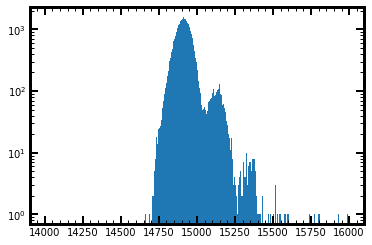

In [5]:
plt.hist(Overscan.flatten(), bins = 1000, range = (14000, 16000))
plt.yscale('log')
plt.show()

In [6]:
### Dimensiones de Overscan
print('Dimensiones Oscan: ', Overscan.shape)
oscan_x = Overscan.shape[1]
oscan_y = Overscan.shape[0]


### Dimensiones de Active Area
print('Dimensiones ActA: ', active_area.shape)
acta_x = active_area.shape[1]
acta_y = active_area.shape[0]

Dimensiones Oscan:  (650, 150)
Dimensiones ActA:  (650, 550)


In [7]:
### Se sustrae la mediana de cada renglón y se crea un arreglo
mean_rows_value = []
for element in np.arange(0, oscan_y):
    row = Overscan[element: element +1, 0: oscan_x]
    num_row = element + 1
    # plt.imshow(row, origin='lower')
    # plt.show()
    # print(row.shape)
    # print(type(row))
    # print(row.sum()/row.shape[1])
    mean_value = np.median(row)
    mean_rows_value.append([mean_value])
    # print((num_row, mean_value))

print(mean_rows_value[0])

[14779.771]


In [8]:
### Se le resta el valor de promedio de cada renglón a su respectivo renglon del area activa
true_active_area = active_area - mean_rows_value
print(active_area[1][1])
print(true_active_area[1][1])
### Se le resta el valor de promedio de cada renglón a su respectivo renglon del oScan
# true_Oscan = Overscan - mean_rows_value


true_Oscan = Overscan
min_oScan = np.min(true_Oscan)
# plt.imshow(true_active_area, origin='lower')

14819.213
33.898438


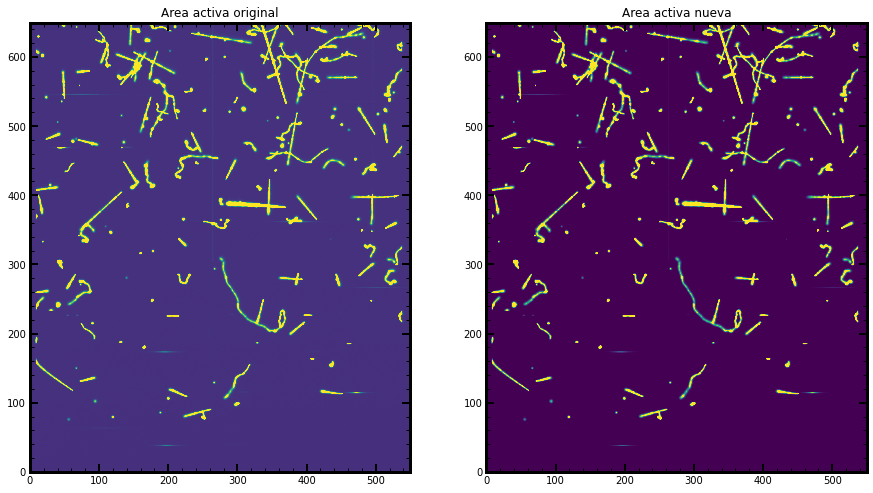

In [9]:
## Se muestra la comparación de la extensión original y despues de quitarle la mediana

Figsize = [15,15]
fig, axs = plt.subplots(1, 2, figsize=Figsize)
# oScan_mask=sk.measure.label(Overscan>=np.max(Overscan) , connectivity=2)
# oScan=ma.masked_array(Overscan,mask=(oScan_mask>0))
Vmin = 1000
Vmax = 100000
axs[0].set_title('Area activa original')
axs[1].set_title('Area activa nueva')
x0 = axs[0].imshow(active_area, origin='lower', vmin=Vmin, vmax = Vmax)
x1 = axs[1].imshow(true_active_area, origin='lower', vmin=Vmin, vmax = Vmax)
# plt.colorbar()

# fig.colorbar(x0, ax=axs[0]) 
# fig.colorbar(x1, ax=axs[1])

# print(active_area.max())
# print(true_active_area.max())
plt.show()

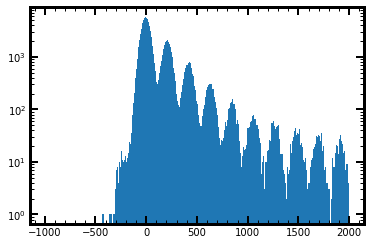

In [10]:
plt.hist(true_active_area.flatten(), bins = 1000, range = (-1000, 2000))
plt.yscale('log')
plt.show()

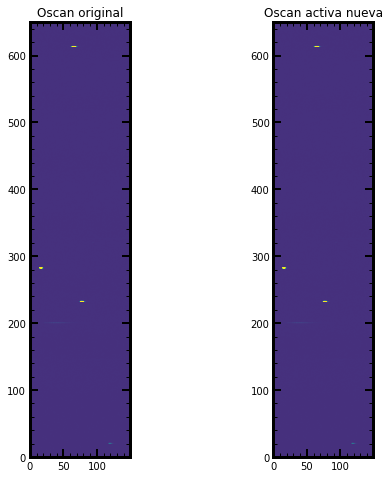

In [11]:
fig, axs = plt.subplots(1, 2, figsize=[8,8])
# oScan_mask=sk.measure.label(Overscan>=np.max(Overscan) , connectivity=2)
# oScan=ma.masked_array(Overscan,mask=(oScan_mask>0))
Vmin = 1000
Vmax = 100000
axs[0].set_title('Oscan original')
axs[1].set_title('Oscan activa nueva')
x0 = axs[0].imshow(Overscan, origin='lower', vmin=Vmin, vmax = Vmax)
x1 = axs[1].imshow(true_Oscan, origin='lower', vmin=Vmin, vmax = Vmax)
# plt.colorbar()

# fig.colorbar(x0, ax=axs[0]) 
# fig.colorbar(x1, ax=axs[1])

# print(active_area.max())
# print(true_active_area.max())
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


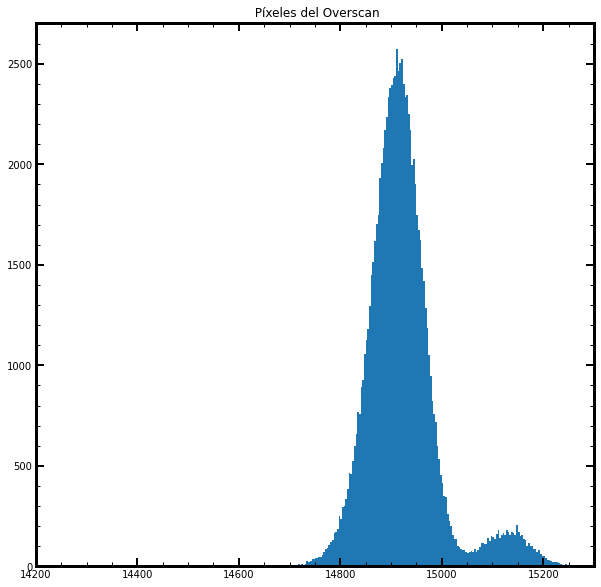

In [12]:
fig_all, axs_all = plt.subplots(1, 1, figsize=(10, 10))

min_oScan = np.min(true_Oscan)

## Generamos el histograma de los pixeles del oScan especificando el rango
bin_heights, bin_borders, _ = axs_all.hist(true_Oscan.flatten(), bins= 300, range = (14250, 15250))# , label="Pixeles del Overscan")
# axs_all.vlines(14651.275, ymin=0, ymax=900, colors='k', linestyle = 'dashed', label = 'Offset')
# axs_all.vlines(14720.0, ymin=0, ymax=2000, colors='r')

axs_all.set_title(' Píxeles del Overscan')
plt.legend()

plt.show()

## Aplanando el Oscan

### Doble Gaussiana

Offset Value:  14907.859  ADUs
Parameters of the Doble-Gaussian Fit
Mean:  6.163630582586351  +-  0.36634031297283354
Sigma:  45.713726324094075  +-  0.22508905253171588
Gain:  214.898584205668  +-  0.7772269312981703
First Peak:  477.5084815575517  +-  2.1227221475970657
Second Peak:  31.509519407425724  +-  0.4647876465218821 

chiSquare: 607.7945703512723
NDegrees of Freedom: 575
chiSquare / NDF : 1.057034035393517
Prob: 0.16631470038613727 

 FCN=607.795 FROM MIGRAD    STATUS=CONVERGED     379 CALLS         380 TOTAL
                     EDM=5.05275e-08    STRATEGY= 1  ERROR MATRIX UNCERTAINTY   3.7 per cent
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           6.16363e+00   3.66340e-01  -8.05464e-05   2.58072e-04
   2  p1           4.57137e+01   2.25089e-01   1.62489e-04   1.06197e-04
   3  p2           2.14899e+02   7.77227e-01  -1.53772e-04   5.70209e-04
   4  p3         

Info in <TCanvas::MakeDefCanvas>:  created default TCanvas with name c1


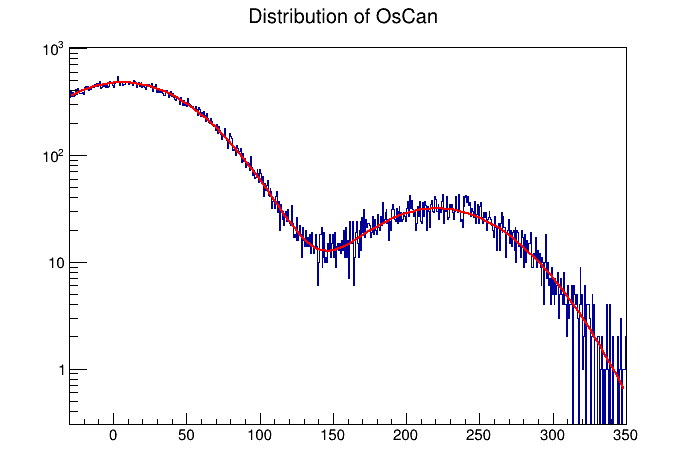

In [13]:
# min_oScan = np.min(true_Oscan)
# extension = 4
Bins = 600
Bins_fit = 600
# Range_fit = [-100, 400]

Range_fit = [-30, 350]
ratio_keV = 0.0037  ## KeV/e-

# data = hdu_list[extension-1].data[:, :550]
data = true_active_area
header = hdu_list[extension-1].header
# oScan=hdu_list[extension-1].data[:,550:]

hist , bins_edges = np.histogram(true_Oscan.flatten(), bins = Bins,  range=(min_oScan, 18000))
offset = bins_edges[np.argmax(hist)]
print('Offset Value: ', offset, ' ADUs')
Overscan_plane = true_Oscan - offset 
fgaus2 = TF1("fgauss2","[3]*exp(-0.5*((x-[0])/[1])^2)+[4]*exp(-0.5*((x-[0]-[2])/[1])^2)",-300,600,5) # TF1("nombre", "funcion escrita como en root", min, max, #parametros)

h3=TH1F("histogram", "Distribution of OsCan",Bins_fit,Range_fit[0],Range_fit[1])
h3.AddDirectory(False)
for pixel_value in Overscan_plane.flatten():
    # if not np.ma.is_masked(pixel_value):
    h3.Fill(pixel_value)
    #print(pixel_value)
fgaus2.SetParameters(0,10,100, 100, 100) # Establecer parametros iniciales del fit, de manera visual es posible determinarlos como una primera aproximacion
# fgaus2.SetParameters(3.999255762274112,62.819921446387646, 197.8901791750652, 106.11699858208667, 4.973093664397046)

h3.Fit(fgaus2)
c1=TCanvas()
c1.SetLogy()
h3.SetStats(0)
h3.Draw()
fgaus2.Draw("same")
c1.Draw()

gStyle.SetOptFit(1100)
gStyle.SetPadGridX (True)

# # fgaus2.Draw('Quiet')
print('Parameters of the Doble-Gaussian Fit')
print('Mean: ', fgaus2.GetParameters()[0],  ' +- ', fgaus2.GetParError(0))
print('Sigma: ', fgaus2.GetParameters()[1],  ' +- ', fgaus2.GetParError(1))
print('Gain: ', fgaus2.GetParameters()[2],  ' +- ', fgaus2.GetParError(2))
print('First Peak: ', fgaus2.GetParameters()[3],  ' +- ', fgaus2.GetParError(3))
print('Second Peak: ', fgaus2.GetParameters()[4],  ' +- ', fgaus2.GetParError(4), '\n')
print("chiSquare: " + str(fgaus2.GetChisquare()))
print("NDegrees of Freedom: " + str(fgaus2.GetNDF()))
print("chiSquare / NDF :", fgaus2.GetChisquare() / fgaus2.GetNDF())
print("Prob:", fgaus2.GetProb(), '\n')


In [14]:
delta_Bin = 0
dict_popt =  oScan_fit_NSAMP324_ROOT(extensión = extension, active_area = data, oScan = true_Oscan, Bins = Bins+delta_Bin, Bins_fit=Bins_fit+delta_Bin,
                                        make_figure_flag = False, range_fit=[-30, 350])

 FCN=607.795 FROM MIGRAD    STATUS=CONVERGED     379 CALLS         380 TOTAL
                     EDM=5.05275e-08    STRATEGY= 1  ERROR MATRIX UNCERTAINTY   3.7 per cent
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           6.16363e+00   3.66340e-01  -8.05464e-05   2.58072e-04
   2  p1           4.57137e+01   2.25089e-01   1.62489e-04   1.06197e-04
   3  p2           2.14899e+02   7.77227e-01  -1.53772e-04   5.70209e-04
   4  p3           4.77508e+02   2.12272e+00   8.76830e-03   7.82842e-06
   5  p4           3.15095e+01   4.64788e-01  -2.55660e-04  -9.05548e-05


In [15]:
##### Sigma en e- ####
sig_ADUs = dict_popt['sigma']
Gain = dict_popt['Gain']
offset = dict_popt['Offset']

sig_elec = abs(( sig_ADUs) / Gain)
print('Sigma: ', sig_elec, ' e-')

Sigma:  0.21272232431435614  e-


In [23]:
dataCal, sigma = data_calibrated_NSAMP(active_area = data, extension = extension, offset = offset, gain = Gain, ratio_keV = ratio_keV, unidades = 1, sigma_ADUs = sig_ADUs)
print('Sigma: ', sigma, ' keV')

Sigma:  0.21272232431435614  keV


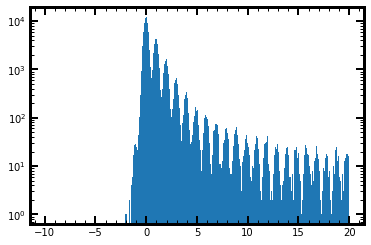

In [24]:
plt.hist(dataCal.flatten(), bins = 1000, range = (-10, 20))
plt.yscale('log')
plt.show()

## No lo sé

In [4]:
extension = 1
Bins = 400
Bins_fit = 600
Range_fit = [-30, 350]


path = '../images/AGO2024/proc_skp_m-009_microchip_T_170__NSAMP_324_NROW_650_NCOL_700_EXPOSURE_0_img_100.fits'
hdu_list = fits.open(path)
data = hdu_list[extension-1].data[:, :550]
hist , bins_edges = np.histogram(data.flatten(), bins = Bins,  range=(14000, 16000))
offset = bins_edges[np.argmax(hist)]
# print('Offset Value: ', offset, ' ADUs')
Active_area_plane = data - offset 

print(Active_area_plane)
h3=TH1F("histogram", "Distribution of Active Area",Bins_fit,Range_fit[0],Range_fit[1])
h3.AddDirectory(False)

for pixel_value in Active_area_plane.flatten():
    # if not np.ma.is_masked(pixel_value):
    h3.Fill(pixel_value)
    #print(pixel_value)

fgaus2 = TF1("fgauss2","[3]*exp(-0.5*((x-[0])/[1])^2)+[4]*exp(-0.5*((x-[0]-[2])/[1])^2)",-300,600,5) # TF1("nombre", "funcion escrita como en root", min, max, #parametros)
fgaus2.SetParameters(0,10,100, 100, 100) # Establecer parametros iniciales del fit, de manera visual es posible determinarlos como una primera aproximacion
h3.Fit(fgaus2)
Gain = fgaus2.GetParameters()[2]


list_path = ['../images/AGO2024/proc_skp_m-009_microchip_T_170__NSAMP_324_NROW_650_NCOL_700_EXPOSURE_0_img_101.fits',]
            #  '/home/labdet/Documents/MauSan/Programas/Repositorio_Git/images/AGO2024/proc_skp_m-009_microchip_T_170__NSAMP_324_NROW_650_NCOL_700_EXPOSURE_0_img_102.fits',]
            #  '/home/labdet/Documents/MauSan/Programas/Repositorio_Git/images/AGO2024/proc_skp_m-009_microchip_T_170__NSAMP_324_NROW_650_NCOL_700_EXPOSURE_0_img_103.fits']
            #  '/home/labdet/Documents/MauSan/Programas/Repositorio_Git/images/AGO2024/proc_skp_m-009_microchip_T_170__NSAMP_324_NROW_650_NCOL_700_EXPOSURE_0_img_104.fits']
            #  '/home/labdet/Documents/MauSan/Programas/Repositorio_Git/images/AGO2024/proc_skp_m-009_microchip_T_170__NSAMP_324_NROW_650_NCOL_700_EXPOSURE_0_img_105.fits']
            #  '/home/labdet/Documents/MauSan/Programas/Repositorio_Git/images/AGO2024/proc_skp_m-009_microchip_T_170__NSAMP_324_NROW_650_NCOL_700_EXPOSURE_0_img_106.fits',
            #  '/home/labdet/Documents/MauSan/Programas/Repositorio_Git/images/AGO2024/proc_skp_m-009_microchip_T_170__NSAMP_324_NROW_650_NCOL_700_EXPOSURE_0_img_107.fits',
            #  '/home/labdet/Documents/MauSan/Programas/Repositorio_Git/images/AGO2024/proc_skp_m-009_microchip_T_170__NSAMP_324_NROW_650_NCOL_700_EXPOSURE_0_img_108.fits',
            #  '/home/labdet/Documents/MauSan/Programas/Repositorio_Git/images/AGO2024/proc_skp_m-009_microchip_T_170__NSAMP_324_NROW_650_NCOL_700_EXPOSURE_0_img_109.fits']

list_data_image = [Active_area_plane]
for index in np.arange(0, len(list_path)):
    hdu_list = fits.open(list_path[index])

    data = hdu_list[extension-1].data[:, :550]
    hist , bins_edges = np.histogram(data.flatten(), bins = Bins,  range=(14000, 16000))
    offset = bins_edges[np.argmax(hist)]
    print('Offset Value: ', offset, ' ADUs')
    Active_area = data - offset 
    
    # plt.hist(Active_area.flatten(), 100, -100, 600)
    h3 = 0
    h3=TH1F("histogram", "Distribution of Active Area",Bins_fit,Range_fit[0],Range_fit[1])
    h3.AddDirectory(False)

    for pixel_value in Active_area.flatten():
        # if not np.ma.is_masked(pixel_value):
        h3.Fill(pixel_value)
        #print(pixel_value)
    
    fgaus2 = TF1("fgauss2","[3]*exp(-0.5*((x-[0])/[1])^2)+[4]*exp(-0.5*((x-[0]-[2])/[1])^2)",-300,600,5) # TF1("nombre", "funcion escrita como en root", min, max, #parametros)
    fgaus2.SetParameters(0,50,100, 100, 100) # Establecer parametros iniciales del fit, de manera visual es posible determinarlos como una primera aproximacion
    h3.Fit(fgaus2)

    Gain_i = fgaus2.GetParameters()[2]

    true_data = Active_area * (Gain / Gain_i)
    
    list_data_image.append(true_data)

# print(len(list_data_image))

# print(element)

Bins = 400
Bins_fit = 600
all_data = 0
for element in list_data_image:
    all_data = all_data + element

print(all_data)


[[-6.1199502e+03 -9.6926270e+02 -1.3625879e+02 ... -1.5022559e+02
  -4.5157227e+01 -1.1643555e+02]
 [-1.0971582e+02 -8.0787109e+01 -2.1541406e+02 ... -6.9351562e+01
  -9.3527344e+01 -9.1984375e+01]
 [-6.3873047e+01 -6.7135742e+01 -1.3534570e+02 ... -1.1458008e+02
  -6.7571289e+01 -6.0333008e+01]
 ...
 [ 3.5135742e+01  8.2542969e+01  5.7241211e+01 ...  5.5688477e+01
   5.8777344e+01  7.5984375e+01]
 [ 1.4738574e+02 -2.3858398e+01  7.2080078e+01 ...  7.9185547e+01
   4.9388672e+01  2.2147266e+02]
 [ 4.0012695e+01 -1.0549805e+01  3.2114258e+01 ...  1.0771484e+00
  -5.1635742e+01  2.8925879e+02]]
Offset Value:  14920.0  ADUs
[[-6.1195884e+03 -9.6920337e+02 -1.3625279e+02 ... -1.5021703e+02
  -4.5152840e+01 -1.1642603e+02]
 [-1.0971310e+02 -8.0779503e+01 -2.1540776e+02 ... -6.9347382e+01
  -9.3533585e+01 -9.1979065e+01]
 [-6.3870663e+01 -6.7131798e+01 -1.3533824e+02 ... -1.1457637e+02
  -6.7567062e+01 -6.0330807e+01]
 ...
 [ 3.5133541e+01  8.2544281e+01  5.7238823e+01 ...  5.5683434e+01
   

Info in <TCanvas::MakeDefCanvas>:  created default TCanvas with name c1
Warning in <Fit>: Abnormal termination of minimization.


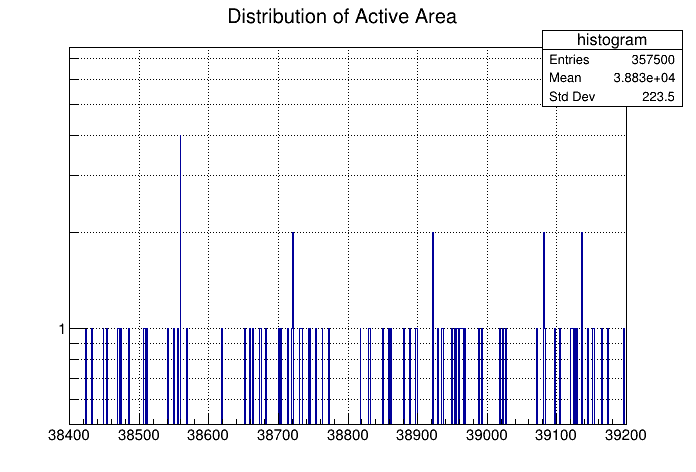

In [317]:

    
# Range_fit = [-100, 30000]
Range_fit = [38400, 39200]

h3=TH1F("histogram", "Distribution of Active Area",Bins_fit,Range_fit[0],Range_fit[1])
h3.AddDirectory(False)

for pixel_value in all_data.flatten():
    # if not np.ma.is_masked(pixel_value):
    h3.Fill(pixel_value)
    #print(pixel_value)

c1=TCanvas()
c1.SetGrid()
c1.SetLogy()
# h3.SetStats(0)
h3.Draw()
fgaus2.Draw("same")
c1.Draw()

## Curva de electrones del area activa

Offset Value:  14920.0  ADUs
Parameters of the Doble-Gaussian Fit
Mean:  -13021039.982700683  +-  1.4142135623730951
Sigma:  40.0  +-  1.4142135623730951
Gain:  31700.0  +-  1.4142135623730951
chiSquare: 212960.0
NDegrees of Freedom: 595
chiSquare / NDF : 357.9159663865546
Prob: 0.0 

 FCN=212960 FROM HESSE     STATUS=FAILED         11 CALLS         239 TOTAL
                     EDM=0    STRATEGY= 1  ERROR MATRIX UNCERTAINTY 100.0 per cent
  EXT PARAMETER                APPROXIMATE        STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0          -1.30210e+07   1.41421e+00   0.00000e+00   0.00000e+00
   2  p1           4.00000e+01   1.41421e+00   0.00000e+00   0.00000e+00
   3  p2           3.17000e+04   1.41421e+00   0.00000e+00   0.00000e+00
   4  p3           8.00000e+00   1.41421e+00   0.00000e+00   0.00000e+00
   5  p4           7.00000e+00   1.41421e+00   0.00000e+00   0.00000e+00


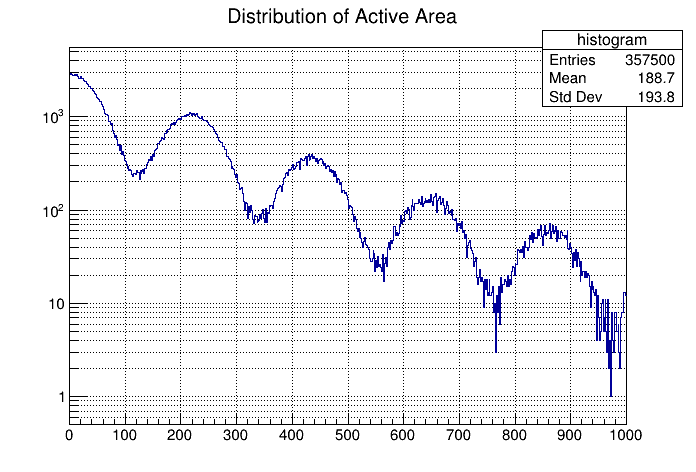

In [295]:
# min_oScan = np.min(true_Oscan)
# extension = 4
Bins = 400
Bins_fit = 600
# Range_fit = [-100, 400]

Range_fit = [0, 1000]
# Range_fit = [38400, 39200]
# Range_fit = [-50, 300] # Primeros dos picos
# Range_fit = [140, 530] # Segundo y tercer pico
# Range_fit = [390, 740] # tercer y cuarto pico
# Range_fit = [590, 940] # cuarto y quinto pico
# Range_fit = [1030, 1350] # quinto y sexto pico
# Range_fit = [1200, 1580] # sexto y séptimo pico
# Range_fit = [1400, 1800] # séptimo y octavo pico
# Range_fit = [1635, 2000] # octavo y noveno pico
# Range_fit = [1880, 2180] # noveno y decimo pico
# Range_fit = [2250, 2500] # decimo y decimoprimer pico
# Range_fit = [2450, 2700] # decimo y decimoprimer pico
# Range_fit = [2690, 2860] # decimo y decimoprimer pico
# Range_fit = [2860, 3100] # decimo y decimoprimer pico
# Range_fit = [2860, 3100] # decimo y decimoprimer pico

# Range_fit = [10060, 10300] # Pico 50
# Range_fit = [20850, 21140] # Pico 100
# Range_fit = [31470, 31650] # Pico 150




ratio_keV = 0.0037  ## KeV/e-

data = hdu_list[extension-1].data[:, :550]
# print(data[0:1])
# data = true_active_area
header = hdu_list[extension-1].header
# oScan=hdu_list[extension-1].data[:,550:]

hist , bins_edges = np.histogram(data.flatten(), bins = Bins,  range=(14000, 16000))
offset = bins_edges[np.argmax(hist)]
print('Offset Value: ', offset, ' ADUs')
Overscan_plane = data - offset 
fgaus2 = TF1("fgauss2","[3]*exp(-0.5*((x-[0])/[1])^2)+[4]*exp(-0.5*((x-[0]-[2])/[1])^2)",Range_fit[0],Range_fit[1],5) # TF1("nombre", "funcion escrita como en root", min, max, #parametros)

h3=TH1F("histogram", "Distribution of Active Area",Bins_fit,Range_fit[0],Range_fit[1])
h3.AddDirectory(False)
for pixel_value in Overscan_plane.flatten():
    # if not np.ma.is_masked(pixel_value):
    h3.Fill(pixel_value)
    #print(pixel_value)
# fgaus2.SetParameters(0,1,218, 1000, 500) # Establecer parametros iniciales del fit, de manera visual es posible determinarlos como una primera aproximacion
# fgaus2.SetParameters(218,1, 433, 500, 100)
# fgaus2.SetParameters(433,40, 570, 100, 50)
# fgaus2.SetParameters(647,40, 861, 100, 50)
# fgaus2.SetParameters(858,40, 1068, 100, 50)
# fgaus2.SetParameters(1069,40, 1279, 100, 50)
# fgaus2.SetParameters(1708,50, 1930, 10, 11)
# fgaus2.SetParameters(1930, 40, 2130, 8, 8)
# fgaus2.SetParameters(2130, 40, 2350, 20, 15)
# fgaus2.SetParameters(2130, 40, 2350, 20, 15)
# fgaus2.SetParameters(10170, 40, 10400, 8,7) # Pico 50
# fgaus2.SetParameters(21000, 40, 21400, 8,7) # Pico 50
fgaus2.SetParameters(31500, 40, 31700, 8,7) # Pico 50



# fgaus2.SetParameters(3.999255762274112,62.819921446387646, 197.8901791750652, 106.11699858208667, 4.973093664397046)

h3.Fit(fgaus2)
c1=TCanvas()
c1.SetGrid()
c1.SetLogy()
# h3.SetStats(0)
h3.Draw()
fgaus2.Draw("same")
c1.Draw()

# gStyle.SetOptFit(1100)
# gStyle.SetPadGridX (True)

# fgaus2.Draw('Quiet')
print('Parameters of the Doble-Gaussian Fit')
print('Mean: ', fgaus2.GetParameters()[0],  ' +- ', fgaus2.GetParError(0))
print('Sigma: ', fgaus2.GetParameters()[1],  ' +- ', fgaus2.GetParError(1))
print('Gain: ', fgaus2.GetParameters()[2],  ' +- ', fgaus2.GetParError(2))
# print('First Peak: ', fgaus2.GetParameters()[0],  ' +- ', fgaus2.GetParError(0))
# print('Second Peak: ', fgaus2.GetParameters()[4],  ' +- ', fgaus2.GetParError(4), '\n')
print("chiSquare: " + str(fgaus2.GetChisquare()))
print("NDegrees of Freedom: " + str(fgaus2.GetNDF()))
print("chiSquare / NDF :", fgaus2.GetChisquare() / fgaus2.GetNDF())
print("Prob:", fgaus2.GetProb(), '\n')


## Ajuste de curva

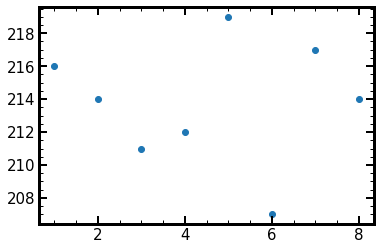

In [115]:
list_gains = [216, 214, 211, 212, 219, 207, 217, 214]
list_points = [1,2,3,4,5,6,7,8]

list_err_gains = [0.289, 0.382, 0.771, 1.09, 2.85, 3.212, 2.473, 3.317, 5.216]
list_err_poinst = [0,0,0,0,0,0,0,0]

plt.scatter(list_points, list_gains)

Parameters of the Fit
Origen:  216.53946426901  +-  0.40159085233487296
Pend:  -1.0166122100398591  +-  0.19955255966336652
chiSquare: 35.4808703849618
NDegrees of Freedom: 6
chiSquare / NDF : 5.913478397493633
Prob: 3.4768909385202316e-06 

 FCN=35.4809 FROM MIGRAD    STATUS=CONVERGED      35 CALLS          36 TOTAL
                     EDM=5.95235e-20    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           2.16539e+02   4.01591e-01   6.31295e-04   1.06926e-09
   2  p1          -1.01661e+00   1.99553e-01   3.13694e-04   3.11449e-09


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c2


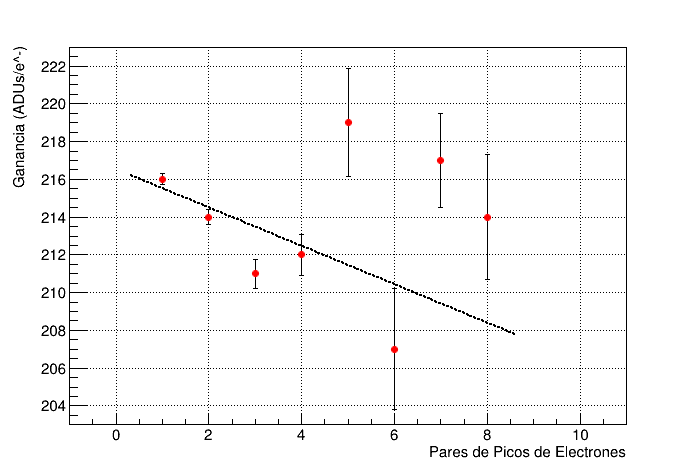

In [181]:
GRprofXY = TGraphErrors()
lox = 0
hix = 10

for index in np.arange(0, len(list_gains)):
    GRprofXY.SetPoint(int(index), list_points[index], list_gains[index])
    GRprofXY.SetPointError(int(index), list_err_poinst[index], list_err_gains[index])

fitline = TF1("fitline", "[0] + [1]*x",lox,hix) 
fitline.SetParameters(215, 1)
fitline.SetLineStyle(2)
fitline.SetLineColor(1)
GRprofXY.Fit("fitline")  #### Funcionó aunque los paŕametros iniciales fueron malos


NBX=10
NBY=220
canv = TCanvas("c2")
canv.SetGrid()
frame = TH2F("frame", "", NBX+1,-1,NBX+1,NBY+1,NBY-17,NBY+3)
frame.GetXaxis().SetTitle("Pares de Picos de Electrones")
frame.GetYaxis().SetTitle("Ganancia (ADUs/e^-)")
frame.SetStats(0)
frame.Draw()


GRprofXY.SetMarkerStyle(20)
GRprofXY.SetMarkerSize(0.8)
GRprofXY.SetMarkerColor(2)
GRprofXY.Draw("P same")
canv.Draw()

print('Parameters of the Fit')
print('Origen: ', fitline.GetParameters()[0],  ' +- ', fitline.GetParError(0))
print('Pend: ', fitline.GetParameters()[1],  ' +- ', fitline.GetParError(1))

print("chiSquare: " + str(fitline.GetChisquare()))
print("NDegrees of Freedom: " + str(fitline.GetNDF()))
print("chiSquare / NDF :", fitline.GetChisquare() / fitline.GetNDF())
print("Prob:", fitline.GetProb(), '\n')

Parameters of the Fit
Origen:  0.9977425665379364  +-  0.0007225820972949141
Pend:  0.004647738919583229  +-  2.647256988599075e-06
chiSquare: 245.60833115362826
NDegrees of Freedom: 16
chiSquare / NDF : 15.350520697101766
Prob: 4.1129744285212795e-43 

 FCN=245.608 FROM MIGRAD    STATUS=CONVERGED     101 CALLS         102 TOTAL
                     EDM=2.20269e-11    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           9.97743e-01   7.22582e-04   4.59832e-06  -1.21231e-03
   2  p1           4.64774e-03   2.64726e-06   1.68473e-08  -2.67676e+00


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c2


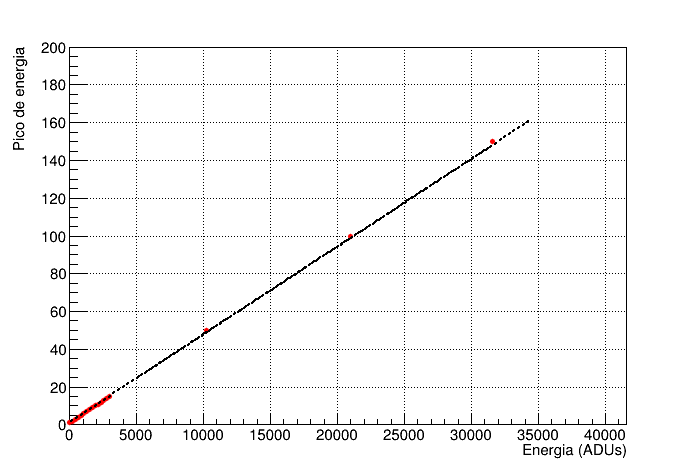

In [139]:
list_means = [-0.75, 217.21, 433.6, 647.21, 857.01, 1068.5, 1287.198, 1491.65, 1707.52, 1918.7188, 2131.781, 2350.208, 2553.9498, 2773.3656, 2986.5140, 10184.484, 20977.635, 31563.77156]
list_picos = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 50, 100, 150]

list_err_means = [0.18, 0.211, 0.529, 0.711, 1.869, 2.241, 1.683, 1.976, 3.597, 7.487, 2.2610, 2.644, 2.5517, 3.402, 3.547, 8.02953, 11.9447, 13.112]
list_err_picos = [0,0,0,0,0,0,0,0,0, 0, 1, 1, 1, 1, 1, 1, 1, 1]


GRprofXY = TGraphErrors()
lox = 5000
hix = list_means[-1]

for index in np.arange(0, len(list_means)):
    GRprofXY.SetPoint(int(index), list_means[index], list_picos[index])
    GRprofXY.SetPointError(int(index), list_err_means[index], list_err_picos[index])


fitline = TF1("fitline", "[0] + [1]*x",lox,hix) 
fitline.SetParameters(1, 1)
fitline.SetLineStyle(2)
fitline.SetLineColor(1)
GRprofXY.Fit("fitline")  


# xlow = 5000
# xhi = list_means[-1]
# fitnonline = TF1("fitnonline", "[0]+[1]*x/(1+[2]*x)", xlow, xhi) 
# fitnonline.SetParameters(1.0, 0.01, 0.0001)
# fitnonline.SetLineStyle(4)
# fitnonline.SetLineColor(3)
# GRprofXY.Fit("fitnonline") 


NBX= int(list_means[-1]) + 10000
NBY= list_picos[-1] + 50
canv = TCanvas("c2")
canv.SetGrid()
# canv.SetLogx()

frame = TH2F("frame", "", NBX-1,-1,NBX+1,NBY+1,0, NBY)
frame.GetXaxis().SetTitle("Energia (ADUs)")
frame.GetYaxis().SetTitle("Pico de energia")
frame.SetStats(0)
frame.Draw()


GRprofXY.SetMarkerStyle(20)
GRprofXY.SetMarkerSize(0.5)
GRprofXY.SetMarkerColor(2)
GRprofXY.Draw("P same")
fitline.Draw("L same")
# fitnonline.Draw("L same")
canv.Draw()

print('Parameters of the Fit')
print('Origen: ', fitline.GetParameters()[0],  ' +- ', fitline.GetParError(0))
print('Pend: ', fitline.GetParameters()[1],  ' +- ', fitline.GetParError(1))

print("chiSquare: " + str(fitline.GetChisquare()))
print("NDegrees of Freedom: " + str(fitline.GetNDF()))
print("chiSquare / NDF :", fitline.GetChisquare() / fitline.GetNDF())
print("Prob:", fitline.GetProb(), '\n')


# print('Parameters of the Non-linear Fit')
# print('Origen: ', fitnonline.GetParameters()[0],  ' +- ', fitnonline.GetParError(0))
# print('Pend: ', fitnonline.GetParameters()[1],  ' +- ', fitnonline.GetParError(1))
# print('Non-linear term: ', fitnonline.GetParameters()[2],  ' +- ', fitnonline.GetParError(2))

# print("chiSquare: " + str(fitnonline.GetChisquare()))
# print("NDegrees of Freedom: " + str(fitnonline.GetNDF()))
# print("chiSquare / NDF :", fitnonline.GetChisquare() / fitnonline.GetNDF())
# print("Prob:", fitnonline.GetProb(), '\n')


Parameters of the Fit
Origen:  1.0035448473738473  +-  0.0008508627192979266
Pend:  0.0047259770390481945  +-  2.545184229296833e-05
chiSquare: 0.8110670174666155
NDegrees of Freedom: 3
chiSquare / NDF : 0.2703556724888718
Prob: 0.8468181587104489 

 FCN=0.811067 FROM MIGRAD    STATUS=CONVERGED      79 CALLS          80 TOTAL
                     EDM=7.81495e-09    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           1.00354e+00   8.50863e-04   5.59037e-07   1.46829e-01
   2  p1           4.72598e-03   2.54518e-05   1.67209e-08  -3.14415e-01


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c2


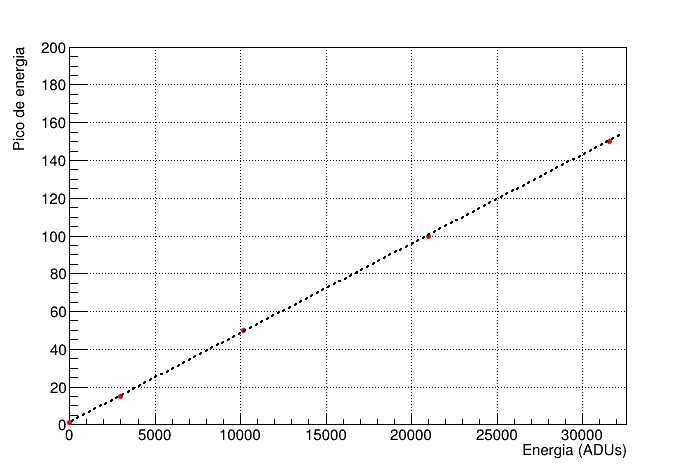

In [141]:
list_means = [-0.75, 2986.5140, 10184.484, 20977.635, 31563.77156]
list_picos = [1, 15, 50, 100, 150]

list_err_means = [0.18, 3.547, 8.02953, 11.9447, 13.112]
list_err_picos = [0, 1, 1, 1, 1]


GRprofXY = TGraphErrors()
lox = 0
hix = list_means[-1]

for index in np.arange(0, len(list_means)):
    GRprofXY.SetPoint(int(index), list_means[index], list_picos[index])
    GRprofXY.SetPointError(int(index), list_err_means[index], list_err_picos[index])


fitline = TF1("fitline", "[0] + [1]*x",lox,hix) 
fitline.SetParameters(1, 1)
fitline.SetLineStyle(2)
fitline.SetLineColor(1)
GRprofXY.Fit("fitline")  


# xlow = 5000
# xhi = list_means[-1]
# fitnonline = TF1("fitnonline", "[0]+[1]*x/(1+[2]*x)", xlow, xhi) 
# fitnonline.SetParameters(1.0, 0.01, 0.0001)
# fitnonline.SetLineStyle(4)
# fitnonline.SetLineColor(3)
# GRprofXY.Fit("fitnonline") 


NBX= int(list_means[-1]) + 1000
NBY= list_picos[-1] + 50
canv = TCanvas("c2")
canv.SetGrid()
# canv.SetLogx()

frame = TH2F("frame", "", NBX-1,-1,NBX+1,NBY+1,0, NBY)
frame.GetXaxis().SetTitle("Energia (ADUs)")
frame.GetYaxis().SetTitle("Pico de energia")
frame.SetStats(0)
frame.Draw()


GRprofXY.SetMarkerStyle(20)
GRprofXY.SetMarkerSize(0.5)
GRprofXY.SetMarkerColor(2)
GRprofXY.Draw("P same")
# fitline.Draw("L same")
# fitnonline.Draw("L same")
canv.Draw()

print('Parameters of the Fit')
print('Origen: ', fitline.GetParameters()[0],  ' +- ', fitline.GetParError(0))
print('Pend: ', fitline.GetParameters()[1],  ' +- ', fitline.GetParError(1))

print("chiSquare: " + str(fitline.GetChisquare()))
print("NDegrees of Freedom: " + str(fitline.GetNDF()))
print("chiSquare / NDF :", fitline.GetChisquare() / fitline.GetNDF())
print("Prob:", fitline.GetProb(), '\n')


# print('Parameters of the Non-linear Fit')
# print('Origen: ', fitnonline.GetParameters()[0],  ' +- ', fitnonline.GetParError(0))
# print('Pend: ', fitnonline.GetParameters()[1],  ' +- ', fitnonline.GetParError(1))
# print('Non-linear term: ', fitnonline.GetParameters()[2],  ' +- ', fitnonline.GetParError(2))

# print("chiSquare: " + str(fitnonline.GetChisquare()))
# print("NDegrees of Freedom: " + str(fitnonline.GetNDF()))
# print("chiSquare / NDF :", fitnonline.GetChisquare() / fitnonline.GetNDF())
# print("Prob:", fitnonline.GetProb(), '\n')


## Multiples imágenes (ADUs)

Offset Value:  14910.0  ADUs
213.37272818585134
Offset Value:  14920.0  ADUs
213.36905363116543
Offset Value:  14916.667  ADUs
212.98389045553398
Offset Value:  14936.667  ADUs
213.71370014412574
Offset Value:  14950.0  ADUs
211.75901948980717
Offset Value:  14920.0  ADUs
214.02376241563678
Offset Value:  14923.333  ADUs
213.92345935636556
Offset Value:  14923.333  ADUs
212.9227245177964
Offset Value:  14940.0  ADUs
211.71460430569616


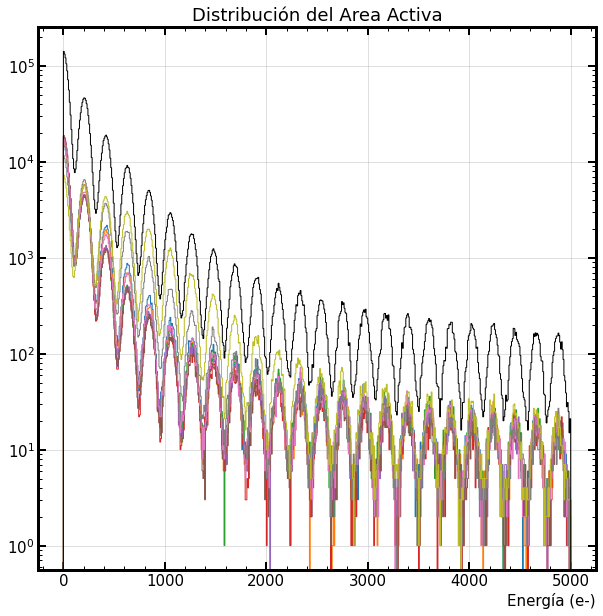

 FCN=620.333 FROM MIGRAD    STATUS=CONVERGED     396 CALLS         397 TOTAL
                     EDM=3.59104e-09    STRATEGY= 1  ERROR MATRIX UNCERTAINTY   2.2 per cent
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           4.23587e+00   3.79769e-01   3.29675e-04  -6.10657e-05
   2  p1           4.55625e+01   2.29284e-01  -7.65433e-05   3.64764e-04
   3  p2           2.13373e+02   7.67830e-01  -3.63529e-04  -8.35775e-05
   4  p3           4.77515e+02   2.14453e+00   3.76537e-04   3.42964e-06
   5  p4           3.15066e+01   4.68584e-01   8.66090e-05   1.91530e-04
 FCN=624.591 FROM MIGRAD    STATUS=CONVERGED     359 CALLS         360 TOTAL
                     EDM=6.70395e-10    STRATEGY= 1  ERROR MATRIX UNCERTAINTY   1.7 per cent
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p

In [18]:
extension = 1
Bins = 600
Bins_fit = 600
Range_fit = [-30, 350]

list_path = ['../images/AGO2024/proc_skp_m-009_microchip_T_170__NSAMP_324_NROW_650_NCOL_700_EXPOSURE_0_img_100.fits',
             '../images/AGO2024/proc_skp_m-009_microchip_T_170__NSAMP_324_NROW_650_NCOL_700_EXPOSURE_0_img_101.fits',
             '../images/AGO2024/proc_skp_m-009_microchip_T_170__NSAMP_324_NROW_650_NCOL_700_EXPOSURE_0_img_102.fits',
             '../images/AGO2024/proc_skp_m-009_microchip_T_170__NSAMP_324_NROW_650_NCOL_700_EXPOSURE_0_img_103.fits',
             '../images/AGO2024/proc_skp_m-009_microchip_T_170__NSAMP_324_NROW_650_NCOL_700_EXPOSURE_0_img_104.fits',
             '../images/AGO2024/proc_skp_m-009_microchip_T_170__NSAMP_324_NROW_650_NCOL_700_EXPOSURE_0_img_105.fits',
             '../images/AGO2024/proc_skp_m-009_microchip_T_170__NSAMP_324_NROW_650_NCOL_700_EXPOSURE_0_img_106.fits',
             '../images/AGO2024/proc_skp_m-009_microchip_T_170__NSAMP_324_NROW_650_NCOL_700_EXPOSURE_0_img_107.fits',
             '../images/AGO2024/proc_skp_m-009_microchip_T_170__NSAMP_324_NROW_650_NCOL_700_EXPOSURE_0_img_108.fits',]
            #  '../images/AGO2024/proc_skp_m-009_microchip_T_170__NSAMP_324_NROW_650_NCOL_700_EXPOSURE_0_img_109.fits']
list_data_image = []
Gain_ref = 213.37272818066896

c1=TCanvas()
c1.SetGrid()
c1.SetLogy()
# h3.SetStats(0)

fig, axs = plt.subplots(figsize = [10,10])

for index in np.arange(0, len(list_path)):
    hdu_list = fits.open(list_path[index])
    # hdu_list = fits.open(path)
    active_area = hdu_list[extension-1].data[:, :550]
    Overscan = hdu_list[extension - 1].data[:, 550:]

    # print('Dimensiones Oscan: ', Overscan.shape)
    oscan_x = Overscan.shape[1]
    oscan_y = Overscan.shape[0]


    ### Dimensiones de Active Area
    # print('Dimensiones ActA: ', active_area.shape)
    acta_x = active_area.shape[1]
    acta_y = active_area.shape[0]

    ### Se sustrae la mediana de cada renglón y se crea un arreglo
    mean_rows_value = []

    for element in np.arange(0, oscan_y):
        row = Overscan[element: element +1, 0: oscan_x]
        num_row = element + 1
        # plt.imshow(row, origin='lower')
        # plt.show()
        # print(row.shape)
        # print(type(row))
        # print(row.sum()/row.shape[1])
        mean_value = np.median(row)
        mean_rows_value.append([mean_value])
        # print((num_row, mean_value))

    ### Se le resta el valor de promedio de cada renglón a su respectivo renglon del area activa
    true_active_area = active_area - mean_rows_value
    # true_active_area = active_area

        
    hist , bins_edges = np.histogram(Overscan.flatten(), bins = Bins,  range=(14000, 16000))
    offset = bins_edges[np.argmax(hist)]
    print('Offset Value: ', offset, ' ADUs')
    # Active_area_plane = true_active_area - offset 
    Overscan_plane = Overscan - offset 
    

    h3=TH1F("histogram", "Distribution of Active Area",Bins_fit,Range_fit[0],Range_fit[1])
    h3.AddDirectory(False)

    for pixel_value in Overscan_plane.flatten():
        # if not np.ma.is_masked(pixel_value):
        h3.Fill(pixel_value)
        #print(pixel_value)

    fgaus2 = TF1("fgauss2","[3]*exp(-0.5*((x-[0])/[1])^2)+[4]*exp(-0.5*((x-[0]-[2])/[1])^2)",-300,600,5) # TF1("nombre", "funcion escrita como en root", min, max, #parametros)
    fgaus2.SetParameters(0,10,100, 100, 100) # Establecer parametros iniciales del fit, de manera visual es posible determinarlos como una primera aproximacion
    h3.Fit(fgaus2)
    Gain_i = fgaus2.GetParameters()[2]
    sig_ADUs = fgaus2.GetParameters()[1]
    print(Gain_i)

    ## SEcalibran los datos en electrones ##
    dataCal, _ = data_calibrated_NSAMP(active_area = true_active_area, extension = extension, offset = offset, gain = Gain_i, ratio_keV = 0.00036, unidades = 0, sigma_ADUs = sig_ADUs)

    # hAcA=TH1F("histogram", "Distribution of Active Area",Bins_fit, 0, 2000)
    # hAcA.AddDirectory(False)
    # for pixel_value in dataCal.flatten():
    #     # if not np.ma.is_masked(pixel_value):
    #     hAcA.Fill(pixel_value)
    #     #print(pixel_value)

    # axs.hist(dataCal.flatten(), bins = Bins, range = [0, 10],  histtype = 'step')
    # plt.yscale('log')
    # hist , bins_edges = np.histogram(data.flatten(), bins = Bins,  range=(14000, 16000))
    # offset = bins_edges[np.argmax(hist)]
    # print('Offset Value: ', offset, ' ADUs')
    # Active_area = data - offset 
    
    # # plt.hist(Active_area.flatten(), 100, -100, 600)
    # h3 = 0
    # h3=TH1F("histogram", "Distribution of Active Area",Bins_fit,Range_fit[0],Range_fit[1])
    # h3.AddDirectory(False)

    # for pixel_value in Active_area.flatten():
    #     # if not np.ma.is_masked(pixel_value):
    #     h3.Fill(pixel_value)
    #     #print(pixel_value)
    
    # fgaus2 = TF1("fgauss2","[3]*exp(-0.5*((x-[0])/[1])^2)+[4]*exp(-0.5*((x-[0]-[2])/[1])^2)",-300,600,5) # TF1("nombre", "funcion escrita como en root", min, max, #parametros)
    # fgaus2.SetParameters(0,50,100, 100, 100) # Establecer parametros iniciales del fit, de manera visual es posible determinarlos como una primera aproximacion
    # h3.Fit(fgaus2)

    # Gain_i = fgaus2.GetParameters()[2]

    # true_data = dataCal * (Gain_i / Gain_ref)
    # hAcA.Draw()

    plot_range = [0, 5000]
    true_data = dataCal.flatten()

    axs.hist(true_data, bins = Bins, range = [plot_range[0], plot_range[1]],  histtype = 'step')

    # print(true_data)
    
    for element in true_data:
        list_data_image.append(element)
    # print(dataCal)

    # c1.Draw()

# fgaus2.Draw("same")

axs.hist(list_data_image, bins = Bins, range =[plot_range[0], plot_range[1]],  histtype = 'step', color = 'k')
plt.xlabel('Energía (e-)')
plt.title('Distribución del Area Activa')
plt.yscale('log')
plt.grid()
plt.show()

 FCN=80.0876 FROM MIGRAD    STATUS=CONVERGED      74 CALLS          75 TOTAL
                     EDM=1.39448e-08    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     9.26388e+00   1.08610e+00   2.77803e-03   1.20228e-04
   2  Mean         3.17445e+04   4.14678e+00   1.80482e-02  -1.73443e-05
   3  Sigma        5.69104e+01   6.05745e+00   8.03073e-05   7.84396e-03


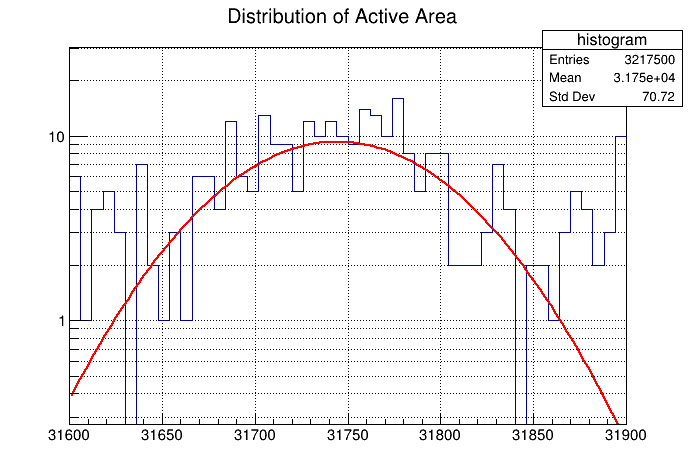

In [85]:
c1=TCanvas()
c1.SetGrid()
c1.SetLogy()
# c1.SetLogx()
Range = [31600, 31900]
# Range = [10, 20]
# Range = [20, 30]
# Range = [30, 40]
# Range = [40, 50]
# Range = [10000, 11000] # ~ 250 bins
# Bins_fit = 100
Bins_fit = 50

histAA=TH1F("histogram", "Distribution of Active Area",Bins_fit, Range[0], Range[1])
histAA.AddDirectory(False)
for pixel_value in list_data_image:
    # if not np.ma.is_masked(pixel_value):
    histAA.Fill(pixel_value)
    #print(pixel_value)

fgaus2 = TF1("fgauss2","[3]*exp(-0.5*((x-[0])/[1])^2)+[4]*exp(-0.5*((x-[0]-[2])/[1])^2)",-300,600,5) # TF1("nombre", "funcion escrita como en root", min, max, #parametros)
fgaus2.SetParameters(4.8,10, 1, 400, 100) # Establecer parametros iniciales del fit, de manera visual es posible determinarlos como una primera aproximacion
histAA.Fit("gaus")


# print('Parameters of the Doble-Gaussian Fit')
# print('Mean: ', fgaus2.GetParameters()[0],  ' +- ', fgaus2.GetParError(0))
# print('Sigma: ', fgaus2.GetParameters()[1],  ' +- ', fgaus2.GetParError(1))
# print('Gain: ', fgaus2.GetParameters()[2],  ' +- ', fgaus2.GetParError(2))
# # print('First Peak: ', fgaus2.GetParameters()[0],  ' +- ', fgaus2.GetParError(0))
# # print('Second Peak: ', fgaus2.GetParameters()[4],  ' +- ', fgaus2.GetParError(4), '\n')
# print("chiSquare: " + str(fgaus2.GetChisquare()))
# print("NDegrees of Freedom: " + str(fgaus2.GetNDF()))
# print("chiSquare / NDF :", fgaus2.GetChisquare() / fgaus2.GetNDF())
# print("Prob:", fgaus2.GetProb(), '\n')

histAA.Draw()
c1.Draw()

Parameters of the Fit
Origen:  0.027154621181402386  +-  0.0004002092326720309
Pend:  0.004716377413493159  +-  8.832618408515003e-07
chiSquare: 137.6303524095752
NDegrees of Freedom: 7
chiSquare / NDF : 19.6614789156536
Prob: 1.5937306133029572e-26 

 FCN=137.63 FROM MIGRAD    STATUS=CONVERGED     157 CALLS         158 TOTAL
                     EDM=6.03282e-10    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           2.71546e-02   4.00209e-04   1.74536e-06  -1.07059e-01
   2  p1           4.71638e-03   8.83262e-07   3.85257e-09  -4.54829e+01


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c2


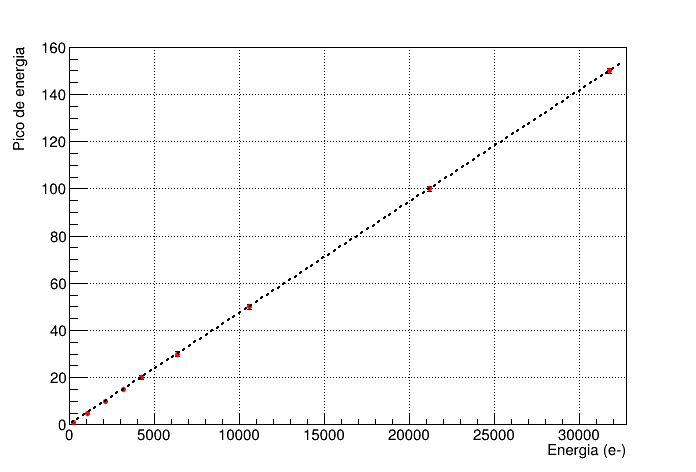

In [88]:
list_means = [2.06375e+02, 1.05205e+03, 2.11725e+03, 3.17997e+03, 4.23982e+03, 6.36622e+03,1.06014e+04, 2.11746e+04, 3.17445e+04]
list_picos = [1, 5, 10, 15, 20, 30, 50, 100, 150]

list_err_means = [6.71113e-02, 2.53065e-01, 6.18362e-01, 9.57621e-01,9.31032e-01, 1.91753e+00, 2.08932e+00, 2.92585e+00, 4.14678e+00]
list_err_picos = [0, 0, 0, 0, 1, 1, 1, 1, 1]


GRprofXY = TGraphErrors()



for index in np.arange(0, len(list_means)):
    GRprofXY.SetPoint(int(index), list_means[index], list_picos[index])
    GRprofXY.SetPointError(int(index), list_err_means[index], list_err_picos[index])

# for index in np.arange(0, len(list_means)):
#     GRprofXY.SetPoint(int(index), list_picos[index], list_means[index])
#     GRprofXY.SetPointError(int(index), list_err_picos[index], list_err_means[index])

lox = 0
hix = list_means[-1]
fitline = TF1("fitline", "[0] + [1]*x",lox,hix) 
fitline.SetParameters(1, 0.0001)
fitline.SetLineStyle(2)
fitline.SetLineColor(1)
GRprofXY.Fit(fitline)  


# xlow = 200
# xhi = list_means[-1]
# fitnonline = TF1("fitnonline", "[0]+[1]*x", xlow, xhi) 
# fitnonline.SetParameters(1.0, 10.,)
# fitnonline.SetLineStyle(4)
# fitnonline.SetLineColor(3)
# GRprofXY.Fit(fitnonline) 


NBX= int(list_means[-1]) + 1000
NBY= list_picos[-1] + 10
canv = TCanvas("c2")
canv.SetGrid()
# canv.SetLogx()

frame = TH2F("frame", "", NBX-1,-1,NBX+1,NBY+1,0, NBY)
frame.GetXaxis().SetTitle("Energia (e-)")
frame.GetYaxis().SetTitle("Pico de energia")

# frame.GetYaxis().SetTitle("Energia (e-)")
# frame.GetXaxis().SetTitle("Pico de energia")
frame.SetStats(0)
frame.Draw()


GRprofXY.SetMarkerStyle(20)
GRprofXY.SetMarkerSize(0.5)
GRprofXY.SetMarkerColor(2)
GRprofXY.Draw("P same")
# fitline.Draw("L same")
# fitnonline.Draw("L same")
canv.Draw()

print('Parameters of the Fit')
print('Origen: ', fitline.GetParameters()[0],  ' +- ', fitline.GetParError(0))
print('Pend: ', fitline.GetParameters()[1],  ' +- ', fitline.GetParError(1))

print("chiSquare: " + str(fitline.GetChisquare()))
print("NDegrees of Freedom: " + str(fitline.GetNDF()))
print("chiSquare / NDF :", fitline.GetChisquare() / fitline.GetNDF())
print("Prob:", fitline.GetProb(), '\n')


# print('Parameters of the Non-linear Fit')
# print('Origen: ', fitnonline.GetParameters()[0],  ' +- ', fitnonline.GetParError(0))
# print('Pend: ', fitnonline.GetParameters()[1],  ' +- ', fitnonline.GetParError(1))
# print('Non-linear term: ', fitnonline.GetParameters()[2],  ' +- ', fitnonline.GetParError(2))

# print("chiSquare: " + str(fitnonline.GetChisquare()))
# print("NDegrees of Freedom: " + str(fitnonline.GetNDF()))
# print("chiSquare / NDF :", fitnonline.GetChisquare() / fitnonline.GetNDF())
# print("Prob:", fitnonline.GetProb(), '\n')


## Multiples imágenes (electrones)

Offset Value:  14910.0  ADUs
213.37272818585134
Offset Value:  14920.0  ADUs
213.36905363116543
Offset Value:  14916.667  ADUs
212.98389045553398
Offset Value:  14936.667  ADUs
213.71370014412574
Offset Value:  14950.0  ADUs
211.75901948980717
Offset Value:  14920.0  ADUs
214.02376241563678
Offset Value:  14923.333  ADUs
213.92345935636556
Offset Value:  14923.333  ADUs
212.9227245177964
Offset Value:  14940.0  ADUs
211.71460430569616


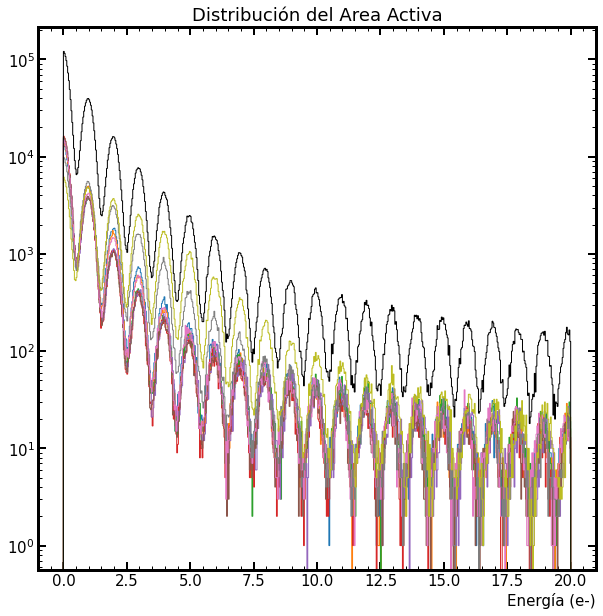

 FCN=620.333 FROM MIGRAD    STATUS=CONVERGED     396 CALLS         397 TOTAL
                     EDM=3.59104e-09    STRATEGY= 1  ERROR MATRIX UNCERTAINTY   2.2 per cent
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           4.23587e+00   3.79769e-01   3.29675e-04  -6.10657e-05
   2  p1           4.55625e+01   2.29284e-01  -7.65433e-05   3.64764e-04
   3  p2           2.13373e+02   7.67830e-01  -3.63529e-04  -8.35775e-05
   4  p3           4.77515e+02   2.14453e+00   3.76537e-04   3.42964e-06
   5  p4           3.15066e+01   4.68584e-01   8.66090e-05   1.91530e-04
 FCN=624.591 FROM MIGRAD    STATUS=CONVERGED     359 CALLS         360 TOTAL
                     EDM=6.70395e-10    STRATEGY= 1  ERROR MATRIX UNCERTAINTY   1.7 per cent
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p

In [13]:
extension = 1
Bins = 600
Bins_fit = 600
Range_fit = [-30, 350]

list_path = ['../images/AGO2024/proc_skp_m-009_microchip_T_170__NSAMP_324_NROW_650_NCOL_700_EXPOSURE_0_img_100.fits',
             '../images/AGO2024/proc_skp_m-009_microchip_T_170__NSAMP_324_NROW_650_NCOL_700_EXPOSURE_0_img_101.fits',
             '../images/AGO2024/proc_skp_m-009_microchip_T_170__NSAMP_324_NROW_650_NCOL_700_EXPOSURE_0_img_102.fits',
             '../images/AGO2024/proc_skp_m-009_microchip_T_170__NSAMP_324_NROW_650_NCOL_700_EXPOSURE_0_img_103.fits',
             '../images/AGO2024/proc_skp_m-009_microchip_T_170__NSAMP_324_NROW_650_NCOL_700_EXPOSURE_0_img_104.fits',
             '../images/AGO2024/proc_skp_m-009_microchip_T_170__NSAMP_324_NROW_650_NCOL_700_EXPOSURE_0_img_105.fits',
             '../images/AGO2024/proc_skp_m-009_microchip_T_170__NSAMP_324_NROW_650_NCOL_700_EXPOSURE_0_img_106.fits',
             '../images/AGO2024/proc_skp_m-009_microchip_T_170__NSAMP_324_NROW_650_NCOL_700_EXPOSURE_0_img_107.fits',
             '../images/AGO2024/proc_skp_m-009_microchip_T_170__NSAMP_324_NROW_650_NCOL_700_EXPOSURE_0_img_108.fits',]
            #  '../images/AGO2024/proc_skp_m-009_microchip_T_170__NSAMP_324_NROW_650_NCOL_700_EXPOSURE_0_img_109.fits']
list_data_image = []
Gain_ref = 213.37272818066896

c1=TCanvas()
c1.SetGrid()
c1.SetLogy()
# h3.SetStats(0)

fig, axs = plt.subplots(figsize = [10,10])

for index in np.arange(0, len(list_path)):
    hdu_list = fits.open(list_path[index])
    # hdu_list = fits.open(path)
    active_area = hdu_list[extension-1].data[:, :550]
    Overscan = hdu_list[extension - 1].data[:, 550:]

    # print('Dimensiones Oscan: ', Overscan.shape)
    oscan_x = Overscan.shape[1]
    oscan_y = Overscan.shape[0]


    ### Dimensiones de Active Area
    # print('Dimensiones ActA: ', active_area.shape)
    acta_x = active_area.shape[1]
    acta_y = active_area.shape[0]

    ### Se sustrae la mediana de cada renglón y se crea un arreglo
    mean_rows_value = []

    for element in np.arange(0, oscan_y):
        row = Overscan[element: element +1, 0: oscan_x]
        num_row = element + 1
        # plt.imshow(row, origin='lower')
        # plt.show()
        # print(row.shape)
        # print(type(row))
        # print(row.sum()/row.shape[1])
        mean_value = np.median(row)
        mean_rows_value.append([mean_value])
        # print((num_row, mean_value))

    ### Se le resta el valor de promedio de cada renglón a su respectivo renglon del area activa
    true_active_area = active_area - mean_rows_value
    # true_active_area = active_area

        
    hist , bins_edges = np.histogram(Overscan.flatten(), bins = Bins,  range=(14000, 16000))
    offset = bins_edges[np.argmax(hist)]
    print('Offset Value: ', offset, ' ADUs')
    # Active_area_plane = true_active_area - offset 
    Overscan_plane = Overscan - offset 
    

    h3=TH1F("histogram", "Distribution of Active Area",Bins_fit,Range_fit[0],Range_fit[1])
    h3.AddDirectory(False)

    for pixel_value in Overscan_plane.flatten():
        # if not np.ma.is_masked(pixel_value):
        h3.Fill(pixel_value)
        #print(pixel_value)

    fgaus2 = TF1("fgauss2","[3]*exp(-0.5*((x-[0])/[1])^2)+[4]*exp(-0.5*((x-[0]-[2])/[1])^2)",-300,600,5) # TF1("nombre", "funcion escrita como en root", min, max, #parametros)
    fgaus2.SetParameters(0,10,100, 100, 100) # Establecer parametros iniciales del fit, de manera visual es posible determinarlos como una primera aproximacion
    h3.Fit(fgaus2)
    Gain_i = fgaus2.GetParameters()[2]
    sig_ADUs = fgaus2.GetParameters()[1]
    print(Gain_i)

    ## SEcalibran los datos en electrones ##
    dataCal, _ = data_calibrated_NSAMP(active_area = true_active_area, extension = extension, offset = offset, gain = Gain_i, ratio_keV = 0.00036, unidades = 1, sigma_ADUs = sig_ADUs)

    hAcA=TH1F("histogram", "Distribution of Active Area",Bins_fit, 0, 20)
    hAcA.AddDirectory(False)
    for pixel_value in dataCal.flatten():
        # if not np.ma.is_masked(pixel_value):
        hAcA.Fill(pixel_value)
        #print(pixel_value)

    # axs.hist(dataCal.flatten(), bins = Bins, range = [0, 10],  histtype = 'step')
    # plt.yscale('log')
    # hist , bins_edges = np.histogram(data.flatten(), bins = Bins,  range=(14000, 16000))
    # offset = bins_edges[np.argmax(hist)]
    # print('Offset Value: ', offset, ' ADUs')
    # Active_area = data - offset 
    
    # # plt.hist(Active_area.flatten(), 100, -100, 600)
    # h3 = 0
    # h3=TH1F("histogram", "Distribution of Active Area",Bins_fit,Range_fit[0],Range_fit[1])
    # h3.AddDirectory(False)

    # for pixel_value in Active_area.flatten():
    #     # if not np.ma.is_masked(pixel_value):
    #     h3.Fill(pixel_value)
    #     #print(pixel_value)
    
    # fgaus2 = TF1("fgauss2","[3]*exp(-0.5*((x-[0])/[1])^2)+[4]*exp(-0.5*((x-[0]-[2])/[1])^2)",-300,600,5) # TF1("nombre", "funcion escrita como en root", min, max, #parametros)
    # fgaus2.SetParameters(0,50,100, 100, 100) # Establecer parametros iniciales del fit, de manera visual es posible determinarlos como una primera aproximacion
    # h3.Fit(fgaus2)

    # Gain_i = fgaus2.GetParameters()[2]

    # true_data = dataCal * (Gain_i / Gain_ref)
    # hAcA.Draw()
    true_data = dataCal.flatten()

    axs.hist(true_data, bins = Bins, range = [0, 20],  histtype = 'step')

    # print(true_data)
    
    for element in true_data:
        list_data_image.append(element)
    # print(dataCal)

    # c1.Draw()

# fgaus2.Draw("same")

axs.hist(list_data_image, bins = Bins, range = [0, 20],  histtype = 'step', color = 'k')
plt.xlabel('Energía (e-)')
plt.title('Distribución del Area Activa')
plt.yscale('log')
plt.show()

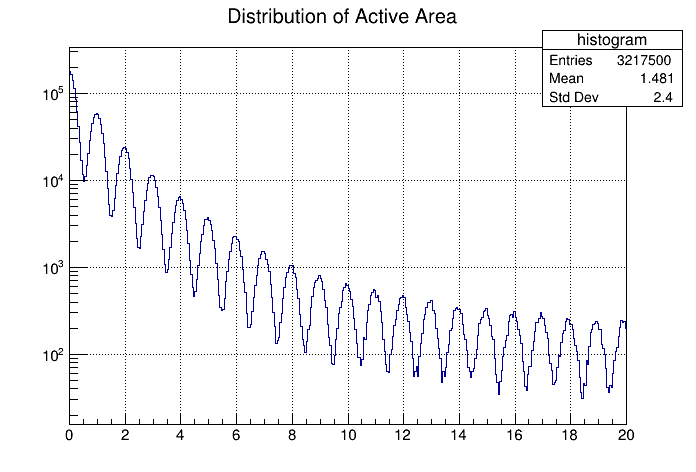

In [8]:
c1=TCanvas()
c1.SetGrid()
c1.SetLogy()
# c1.SetLogx()
Range = [0, 20]
# Range = [10, 20]
# Range = [20, 30]
# Range = [30, 40]
# Range = [40, 50]
# Range = [294, 297] # ~ 250 bins
Bins_fit = 400

histAA=TH1F("histogram", "Distribution of Active Area",Bins_fit, Range[0], Range[1])
histAA.AddDirectory(False)
for pixel_value in list_data_image:
    # if not np.ma.is_masked(pixel_value):
    histAA.Fill(pixel_value)
    #print(pixel_value)

fgaus2 = TF1("fgauss2","[3]*exp(-0.5*((x-[0])/[1])^2)+[4]*exp(-0.5*((x-[0]-[2])/[1])^2)",-300,600,5) # TF1("nombre", "funcion escrita como en root", min, max, #parametros)
fgaus2.SetParameters(4.8,10, 1, 400, 100) # Establecer parametros iniciales del fit, de manera visual es posible determinarlos como una primera aproximacion
# histAA.Fit("gaus")


# print('Parameters of the Doble-Gaussian Fit')
# print('Mean: ', fgaus2.GetParameters()[0],  ' +- ', fgaus2.GetParError(0))
# print('Sigma: ', fgaus2.GetParameters()[1],  ' +- ', fgaus2.GetParError(1))
# print('Gain: ', fgaus2.GetParameters()[2],  ' +- ', fgaus2.GetParError(2))
# # print('First Peak: ', fgaus2.GetParameters()[0],  ' +- ', fgaus2.GetParError(0))
# # print('Second Peak: ', fgaus2.GetParameters()[4],  ' +- ', fgaus2.GetParError(4), '\n')
# print("chiSquare: " + str(fgaus2.GetChisquare()))
# print("NDegrees of Freedom: " + str(fgaus2.GetNDF()))
# print("chiSquare / NDF :", fgaus2.GetChisquare() / fgaus2.GetNDF())
# print("Prob:", fgaus2.GetProb(), '\n')

histAA.Draw()
c1.Draw()

Parameters of the Fit
Origen:  1.0103154686674956  +-  0.0001397868485004198
Pend:  0.9378885173187068  +-  8.84799433767231e-05
chiSquare: 494231.43632070144
NDegrees of Freedom: 19
chiSquare / NDF : 26012.180858984288
Prob: 0.0 

Parameters of the Non-linear Fit
Origen:  1.0103156247424416  +-  0.00013972327354669562
Pend:  0.9378885335998409  +-  8.844786099106848e-05
Non-linear term:  1.6e-322  +-  0.0
chiSquare: 494231.43627964036
NDegrees of Freedom: 19
chiSquare / NDF : 26012.180856823175
Prob: 0.0 

 FCN=494231 FROM MIGRAD    STATUS=CONVERGED      60 CALLS          61 TOTAL
                     EDM=1.20944e-05    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           1.01032e+00   1.39787e-04   0.00000e+00  -4.71989e+01
   2  p1           9.37889e-01   8.84799e-05   0.00000e+00  -3.33346e+01
 FCN=494231 FROM MIGRAD    STATUS=CONVERG

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c2


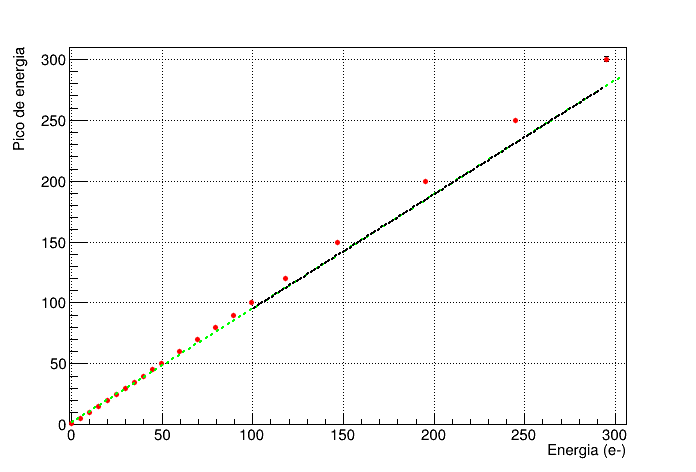

In [42]:
list_means = [-0.0222, 4.951, 9.9491, 14.935, 19.896, 2.48970e+01, 2.98767e+01, 3.48370e+01, 3.98027e+01, 4.48113e+01, 
              4.97893e+01, 5.96377e+01, 6.95188e+01, 7.92982e+01, 8.91824e+01, 99.150, 118.1, 146.9, 195.5, 244.9, 295.1]
list_picos = [1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100, 120, 150, 200, 250, 300]

list_err_means = [0.00015, 1.15417e-03, 2.84331e-03, 4.09970e-03, 5.14658e-03, 7.56068e-03, 1.01108e-02, 1.20870e-02, 1.44099e-02, 1.69816e-02,
                  2.60153e-02, 5.46762e-02, 3.35834e-02,  4.30418e-02,1,1,1,1,1, 1, 1]
list_err_picos = [0,0,0,0,0,0,0,0,0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2]


GRprofXY = TGraphErrors()

lox = 100
hix = list_means[-1]

for index in np.arange(0, len(list_means)):
    GRprofXY.SetPoint(int(index), list_means[index], list_picos[index])
    GRprofXY.SetPointError(int(index), list_err_means[index], list_err_picos[index])

# for index in np.arange(0, len(list_means)):
#     GRprofXY.SetPoint(int(index), list_picos[index], list_means[index])
#     GRprofXY.SetPointError(int(index), list_err_picos[index], list_err_means[index])


fitline = TF1("fitline", "[0] + [1]*x",lox,hix) 
fitline.SetParameters(1, 1)
fitline.SetLineStyle(2)
fitline.SetLineColor(1)
GRprofXY.Fit(fitline)  


xlow = 200
xhi = list_means[-1]
fitnonline = TF1("fitnonline", "[0]+[1]*x", xlow, xhi) 
fitnonline.SetParameters(1.0, 10.,)
fitnonline.SetLineStyle(4)
fitnonline.SetLineColor(3)
GRprofXY.Fit(fitnonline) 


NBX= int(list_means[-1]) + 10
NBY= list_picos[-1] + 10
canv = TCanvas("c2")
canv.SetGrid()
# canv.SetLogx()

frame = TH2F("frame", "", NBX-1,-1,NBX+1,NBY+1,0, NBY)
frame.GetXaxis().SetTitle("Energia (e-)")
frame.GetYaxis().SetTitle("Pico de energia")

# frame.GetYaxis().SetTitle("Energia (e-)")
# frame.GetXaxis().SetTitle("Pico de energia")
frame.SetStats(0)
frame.Draw()


GRprofXY.SetMarkerStyle(20)
GRprofXY.SetMarkerSize(0.5)
GRprofXY.SetMarkerColor(2)
GRprofXY.Draw("P same")
fitline.Draw("L same")
# fitnonline.Draw("L same")
canv.Draw()

print('Parameters of the Fit')
print('Origen: ', fitline.GetParameters()[0],  ' +- ', fitline.GetParError(0))
print('Pend: ', fitline.GetParameters()[1],  ' +- ', fitline.GetParError(1))

print("chiSquare: " + str(fitline.GetChisquare()))
print("NDegrees of Freedom: " + str(fitline.GetNDF()))
print("chiSquare / NDF :", fitline.GetChisquare() / fitline.GetNDF())
print("Prob:", fitline.GetProb(), '\n')


print('Parameters of the Non-linear Fit')
print('Origen: ', fitnonline.GetParameters()[0],  ' +- ', fitnonline.GetParError(0))
print('Pend: ', fitnonline.GetParameters()[1],  ' +- ', fitnonline.GetParError(1))
print('Non-linear term: ', fitnonline.GetParameters()[2],  ' +- ', fitnonline.GetParError(2))

print("chiSquare: " + str(fitnonline.GetChisquare()))
print("NDegrees of Freedom: " + str(fitnonline.GetNDF()))
print("chiSquare / NDF :", fitnonline.GetChisquare() / fitnonline.GetNDF())
print("Prob:", fitnonline.GetProb(), '\n')
